In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd

import time
import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm



## Data "Bottles" and "Cans" are included and divided into Training and Validation Files  

##### The two datasets are in the folder Project_ADS, in which there is another folder called "bottlesandcanstwo" containing the two other folders with "Bottles" and "Cans".

In [2]:
data_dir = os.path.join(os.curdir, '/Users/mervetomen/Downloads/Projekt_ADS/bottlesandcanstwo')
                        
BATCH_SIZE = 32
IMG_SIZE = (192, 192)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")

Found 1607 files belonging to 2 classes.
Using 1286 files for training.
Found 1607 files belonging to 2 classes.
Using 321 files for validation.


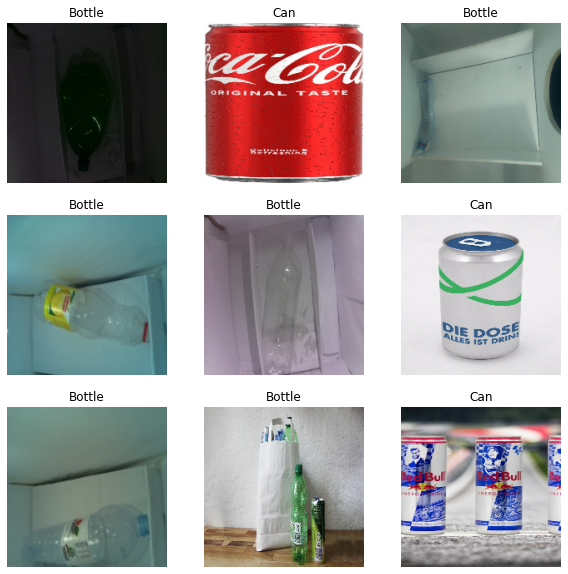

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
val_dataset = validation_dataset.skip(val_batches // 5)

In [5]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 2


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Augmentation

##### Data augementation with flip, rotation and zoom.

In [7]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal'),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(
        height_factor=(0.2, 0.3),
        width_factor=None,
        fill_mode="reflect",
        interpolation="bilinear",
        seed=None,
        fill_value=0.0,
)
    ])

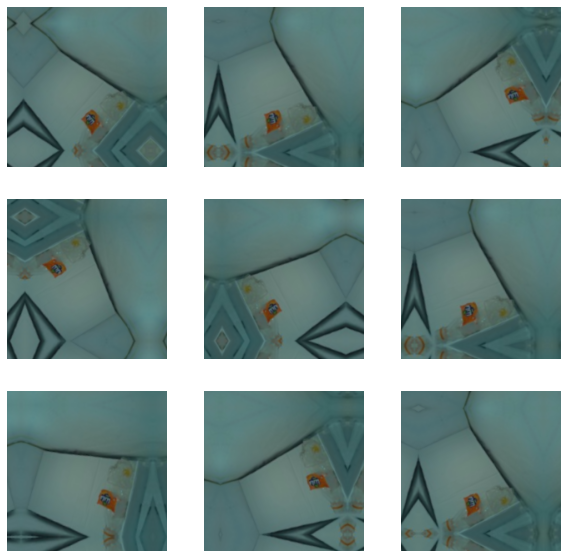

In [8]:
with tf.device('/cpu:0'):
    for image, _ in train_dataset.take(1):
      plt.figure(figsize=(10, 10))
      first_image = image[0]
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## Transfer Learning Model 

##### We will create our model with "Transfer learning Model". For this we create a base model from the MobileNet V2 model, which is already pre-trained.  

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
#rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 96, 96, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 96, 96, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 96, 96, 32)   0           ['bn_Conv1[0][

In [15]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) 
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
#x = tf.keras.layers.Dense(10, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(5, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) 
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 192, 192, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 192, 192, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

## Train the model

In [18]:
initial_epochs = 19

loss0, accuracy0 = model.evaluate(validation_dataset)

11/11 [==============================] - 8s 443ms/step - loss: 1.2127 - accuracy: 0.2461


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.21
initial accuracy: 0.25


In [20]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/19
41/41 [==============================] - 35s 773ms/step - loss: 0.9206 - accuracy: 0.4456 - val_loss: 0.6618 - val_accuracy: 0.6667
Epoch 2/19
41/41 [==============================] - 32s 770ms/step - loss: 0.5953 - accuracy: 0.7201 - val_loss: 0.5537 - val_accuracy: 0.7850
Epoch 3/19
41/41 [==============================] - 32s 755ms/step - loss: 0.5200 - accuracy: 0.7862 - val_loss: 0.5028 - val_accuracy: 0.8131
Epoch 4/19
41/41 [==============================] - 39s 910ms/step - loss: 0.4562 - accuracy: 0.8040 - val_loss: 0.4633 - val_accuracy: 0.8224
Epoch 5/19
41/41 [==============================] - 32s 764ms/step - loss: 0.4194 - accuracy: 0.8157 - val_loss: 0.4320 - val_accuracy: 0.8349
Epoch 6/19
41/41 [==============================] - 33s 772ms/step - loss: 0.3859 - accuracy: 0.8235 - val_loss: 0.4034 - val_accuracy: 0.8474
Epoch 7/19
41/41 [==============================] - 32s 768ms/step - loss: 0.3801 - accuracy: 0.8429 - val_loss: 0.3812 - val_accuracy: 0.8598

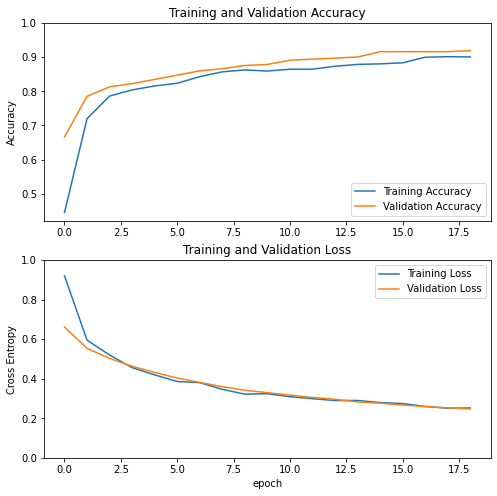

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In [22]:
base_model.trainable = True

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 192, 192, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 192, 192, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

In [26]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 19/29
41/41 [==============================] - 46s 1s/step - loss: 0.2357 - accuracy: 0.9020 - val_loss: 0.2466 - val_accuracy: 0.9034
Epoch 20/29
41/41 [==============================] - 51s 1s/step - loss: 0.1850 - accuracy: 0.9308 - val_loss: 0.1835 - val_accuracy: 0.9439
Epoch 21/29
41/41 [==============================] - 55s 1s/step - loss: 0.1672 - accuracy: 0.9378 - val_loss: 0.1497 - val_accuracy: 0.9470
Epoch 22/29
41/41 [==============================] - 42s 986ms/step - loss: 0.1500 - accuracy: 0.9370 - val_loss: 0.1054 - val_accuracy: 0.9813
Epoch 23/29
41/41 [==============================] - 41s 985ms/step - loss: 0.1219 - accuracy: 0.9518 - val_loss: 0.1248 - val_accuracy: 0.9751
Epoch 24/29
41/41 [==============================] - 43s 1s/step - loss: 0.1184 - accuracy: 0.9495 - val_loss: 0.1042 - val_accuracy: 0.9813
Epoch 25/29
41/41 [==============================] - 43s 1s/step - loss: 0.1008 - accuracy: 0.9580 - val_loss: 0.0696 - val_accuracy: 0.9688
Epoch 2

In [27]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

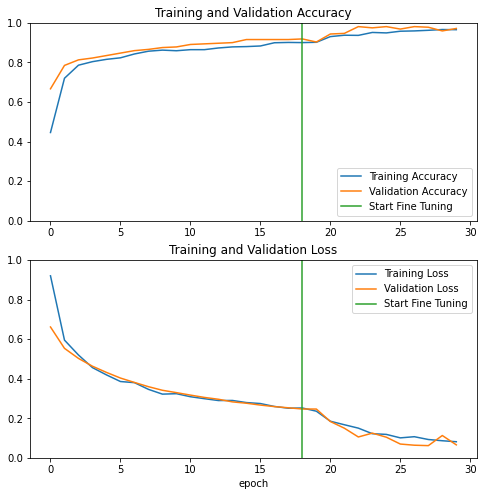

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction

In [29]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 2s 479ms/step - loss: 0.0956 - accuracy: 0.9531
Test accuracy : 0.953125


Predictions:
 [1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Labels:
 [1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


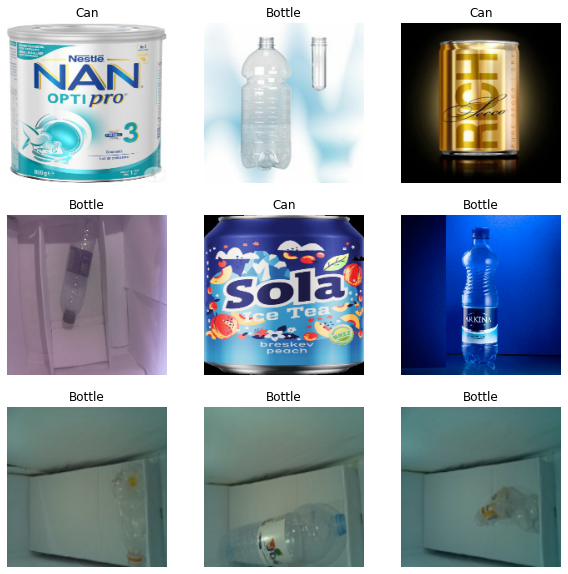

In [30]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Test with own image

##### At this point, your own images are placed in the first line in order to classify them.

This image most likely belongs to Can.


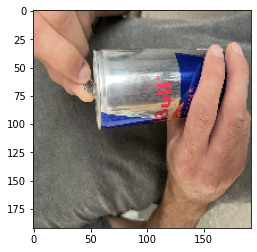

In [52]:
img = tf.keras.utils.load_img("Own_Pictures_Test/Pic_08.jpg", target_size=(192,192) # Paste your picture here .
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 


prediction = model.predict_on_batch(img_array).flatten()

prediction = tf.where(prediction < 0.5, 0, 1)


print(
    "This image most likely belongs to {}."
    .format(class_names[prediction[0]])
)

plt.imshow(img)